In [1]:
##===================== Statements & Copyright ===================##
"""
AUTHOR:  Xiaolong Li, VT
CONTENT: Used for Video-text project
"""
from __future__ import absolute_import, division, print_function
import time
import random
import numpy as np
import os
import cv2
from datetime import datetime
import platform
import logging
import tensorflow as tf
from tensorflow.contrib import slim
import sys
import collections
from copy import deepcopy

import _init_paths
from model import model
from pwc.dataset_base import _DEFAULT_DS_VAL_OPTIONS
from pwc.model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_VAL_OPTIONS
from pwc.net_options import cfg_lg, cfg_sm
from model.model_aggregation import Aggregation
from utils.icdar import restore_rectangle
import lanms
from utils.eval import resize_image, sort_poly, detect
from utils.icdar import load_annotations_solo, check_and_validate_polys
from utils.nms_highlevel import intersection
import matplotlib.pyplot as plt
now = datetime.now()
# used for iou searching and selecting TP, FP, FN #
def eval_single_frame(target, box):
    """
    input params:
        target, python ordered dict
        box, sorted boxes dict from predictions
    """
    TP   = 0
    FP   = 0
    FN   = 0
    precision = 0
    recall = 0
    F_measure = 0
    if not len(box['text_lines']) == 0:
        for t in target:
            d = np.array(t, dtype='int32')
            is_best = 0
            for m in box['text_lines']:
                n = np.array([m['x0'], m['y0'], m['x1'], m['y1'], m['x2'],
                              m['y2'], m['x3'], m['y3']], dtype='int32')

                # pick out the best match
                iou = intersection(n, d)
                if iou>is_best:
                    is_best = iou
            if is_best > 0.5:
                TP = TP+1
            elif is_best == 0:
                FN = FN +1FLAGS.geometry == :
            else:
                FP = FP+1
        if TP > 0:
            precision = TP/(TP+FP)
            recall    = TP/(TP+FN)
            F_measure = 2*precision*recall/(precision+recall)
    return precision, recall, F_measure


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, thickness=2, color=(255, 0, 0))
    return illu


def draw_illu_gt(illu, rst, p, r, f):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.3
    fontColor = (255, 255, 255)
    lineType = 1
    infos = 'Precision ' + str(p)+ ', recall ' + str(r) + ', F_measure ' + str(f)
    cv2.putText(illu, infos,
                (2, 20),
                font,
                0.5,
                (255, 0, 0),
                lineType)
    for t in rst:
        d1 = t.reshape(-1, 2).astype(np.int32)
        cv2.polylines(illu, [d1], isClosed=True, thickness=2, color=(0, 0, 0))
        # bottomLeftCornerOfText = (int(t['x0']), int(t['y0']))

    return illu

def box_generation(index, img, frame_height, frame_width, f_score, f_geometry, polys_array_list, tags_array_list, start):
    timer = collections.OrderedDict([
                        ('net', 0),
                        ('restore', 0),
                        ('nms', 0)
                                   ])
    timer['net'] = time.time() - start

    boxes, timer = detect(score_map=f_score, geo_map=f_geometry, timer=timer)
    ratio_w = 512/frame_width
    ratio_h = 512/frame_height
    if boxes is not None:
        scores = boxes[:,8].reshape(-1)
        boxes = boxes[:, :8].reshape((-1, 4, 2))
        boxes[:, :, 0] /= ratio_w
        boxes[:, :, 1] /= ratio_h

    duration = time.time() - start
    timer['overall'] = duration
    text_lines = []
    if boxes is not None:
        text_lines = []
        for box, score in zip(boxes, scores):
            box = sort_poly(box.astype(np.int32))
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                continue
            tl = collections.OrderedDict(zip(
                ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                map(float, box.flatten())))
            tl['score'] = float(score)
            text_lines.append(tl)
    pred = {
        'text_lines': text_lines
    }
    text_polys, text_tags = polys_array_list[index], tags_array_list[index]
    text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (frame_height, frame_width))
    # out.write(new_img)
    #>>>>>>>>>>>>>>>>>>>>>>>>Evaluation>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    targets = text_polys
    precision, recall, f1 = eval_single_frame(targets, pred)
    new_img = draw_illu(img.copy(), pred)
    new_img1 = draw_illu_gt(new_img.copy(), targets, precision, recall, f1)
    return precision, recall, f1, new_img1

In [2]:
video_set = []
test_data_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test/'
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.mp4'):
            video_set.append(os.path.splitext(file)[0])
print(video_set)

['Video_39_2_3', 'Video_48_6_4', 'Video_5_3_2', 'Video_17_3_1', 'Video_35_2_3', 'Video_6_3_2', 'Video_11_4_1', 'Video_20_5_1', 'Video_49_6_4', 'Video_23_5_2', 'Video_44_6_4', 'Video_32_2_3', 'Video_53_7_4', 'Video_24_5_2', 'Video_1_1_2']


In [3]:
############################# 1. Glabol Variables #########################################
################### 1.1 Training Setup
ICDAR2013 = '/media/dragonx/DataLight/ICDAR2013/'
ARC = '/media/dragonx/DataStorage/ARC/'
if platform.uname()[1] != 'dragonx-H97N-WIFI':
    print("Now it knows it's in a remote cluster")
    ARC = '/work/cascades/lxiaol9/ARC/'
    ICDAR2013 = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/'
tf.app.flags.DEFINE_integer('input_size', 512, '')
tf.app.flags.DEFINE_integer('batch_size_per_gpu', 8, '')
tf.app.flags.DEFINE_integer('seq_len', 5, '')
tf.app.flags.DEFINE_string('gpu_list', '0,1', '')
tf.app.flags.DEFINE_integer('num_gpus', 2, '')
tf.app.flags.DEFINE_string('checkpoint_path', '/work/cascades/lxiaol9/ARC/EAST/checkpoints/FLOW_east/20181109-210436/model.ckpt-31902', '')
# Model 1: EAST
tf.app.flags.DEFINE_string('pretrained_model_path', ARC + "EAST/checkpoints/east/20180921-173054/model.ckpt-56092", '')
# Model 2: PWC-net
tf.app.flags.DEFINE_string('flownet_type', "large", '')
# Model 3: AGG
tf.app.flags.DEFINE_string("prev_checkpoint_path", "/work/cascades/lxiaol9/ARC/EAST/checkpoints/FLOW_east/20181109-210436/model.ckpt-31902", 'path' )
tf.app.flags.DEFINE_boolean("vis", True, '' )
FLAGS = tf.app.flags.FLAGS

Now it knows it's in a remote cluster


In [4]:
save_path = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/test_results_flow/'
if not os.path.exists(save_path):
    os.makedirs(save_path) 

Loading model checkpoint /work/cascades/lxiaol9/ARC/EAST/checkpoints/FLOW_east/20181109-210436/model.ckpt-31902 for eval or testing...

INFO:tensorflow:Restoring parameters from /work/cascades/lxiaol9/ARC/EAST/checkpoints/FLOW_east/20181109-210436/model.ckpt-31902
... model loaded
resnet_v1_50/block1 (5, 64, 64, 256)
resnet_v1_50/block2 (5, 32, 32, 512)
resnet_v1_50/block3 (5, 16, 16, 1024)
resnet_v1_50/block4 (5, 16, 16, 2048)
Shape of f_0 (5, 16, 16, 2048)
Shape of f_1 (5, 32, 32, 512)
Shape of f_2 (5, 64, 64, 256)
Shape of f_3 (5, 128, 128, 64)
Shape of h_0 (5, 16, 16, 2048), g_0 (5, 32, 32, 2048)
Shape of h_1 (5, 32, 32, 128), g_1 (5, 64, 64, 128)
Shape of h_2 (5, 64, 64, 64), g_2 (5, 128, 128, 64)
Shape of h_3 (5, 128, 128, 32), g_3 (5, 128, 128, 32)
Loading model checkpoint /work/cascades/lxiaol9/ARC/EAST/checkpoints/east/20180921-173054/model.ckpt-56092 for eval or testing...

INFO:tensorflow:Restoring parameters from /work/cascades/lxiaol9/ARC/EAST/checkpoints/east/20180921-173

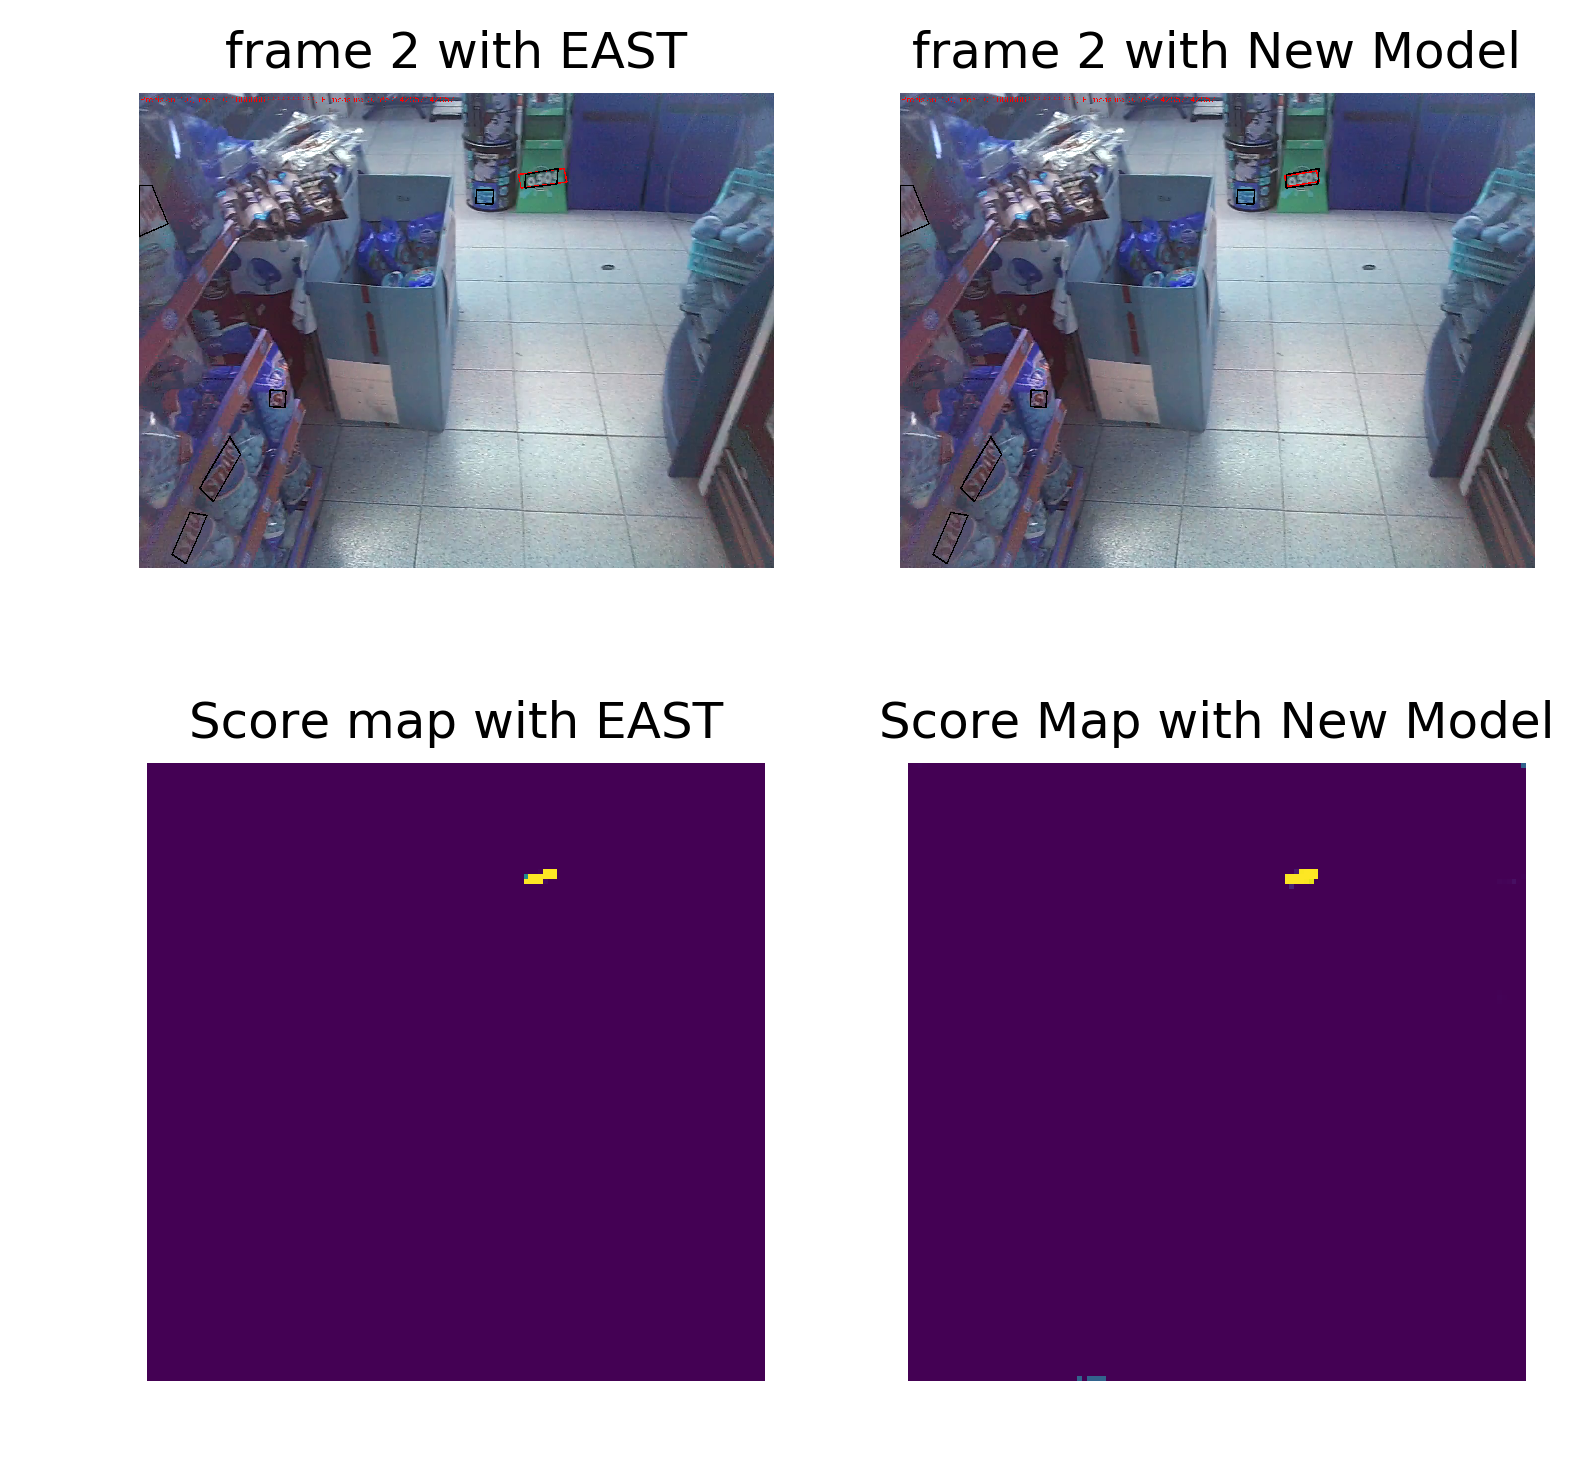

15 text boxes before nms, 1 text boxes after nms
New Model:results on frame 3 is P:1.0, R0.14285714285714285, F:0.25
12 text boxes before nms, 1 text boxes after nms
EAST Model:results on frame 3 is P:1.0, R0.14285714285714285, F:0.25
> <ipython-input-5-34e6b2017a86>(170)main()
-> import pdb;pdb.set_trace()
(Pdb) c


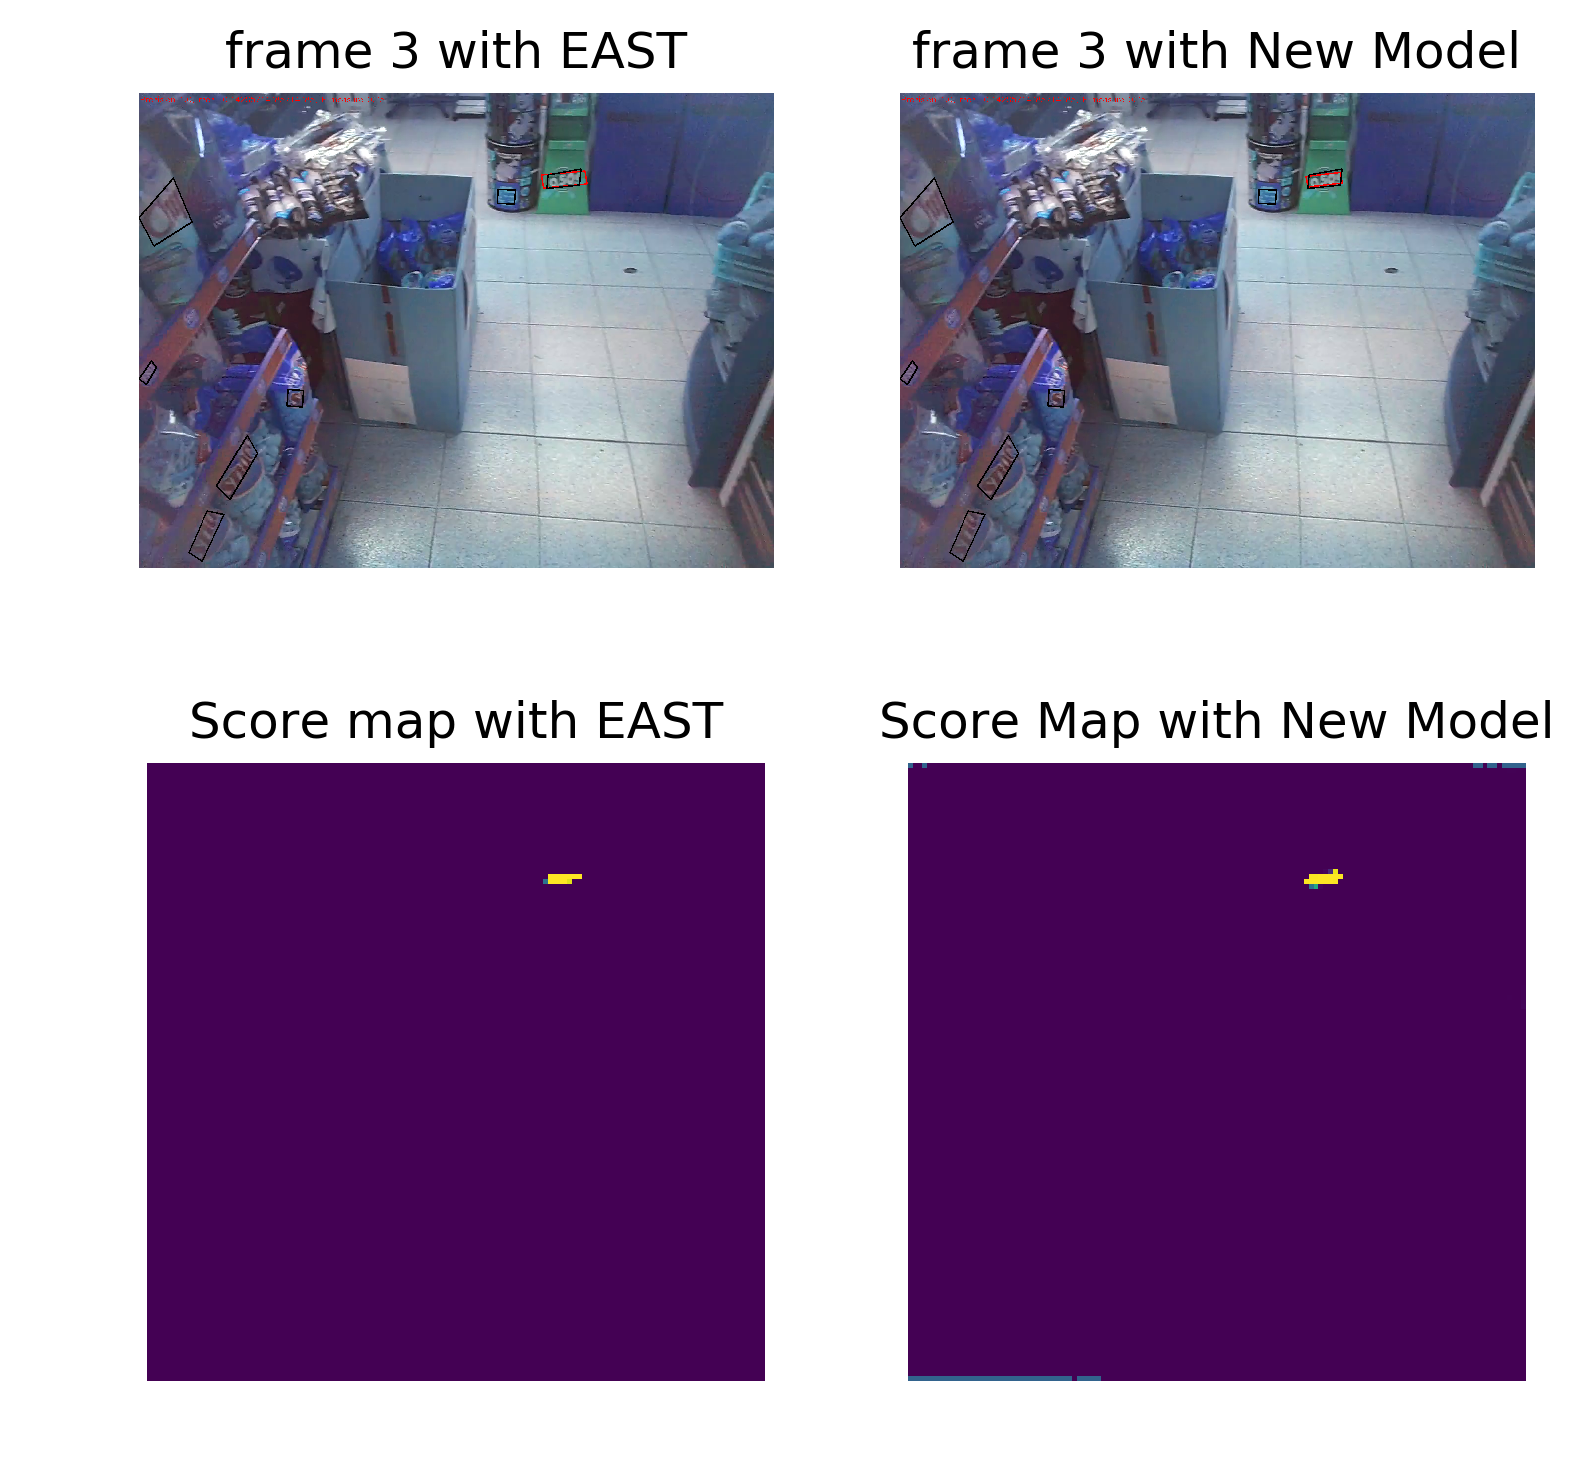

17 text boxes before nms, 1 text boxes after nms
New Model:results on frame 4 is P:1.0, R0.14285714285714285, F:0.25
12 text boxes before nms, 1 text boxes after nms
EAST Model:results on frame 4 is P:1.0, R0.14285714285714285, F:0.25
> <ipython-input-5-34e6b2017a86>(171)main()
-> if FLAGS.vis:


In [ ]:
%matplotlib inline
FLAGS.vis = True
#>>>>>>>>>>>>>>>>>>>>>>>>> specs for AGG >>>>>>>>>>>>>>>>>>>>>>>>>>>#
FLAGS.batch_size_per_gpu = 1
FLAGS.seq_len = 5
FLAGS.gpu_list ='1'
FLAGS.num_gpus  = 1
idname1 = '20181109-210436'
idname2 = '31902'
def main(argv=None):
    ######################## Set up model configurations ######################
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Agg model options >>>>>>>>>>>>>>>>>>>>>>>>>>
    aggre_opts = {
    'verbose': True,
    'ckpt_path': FLAGS.prev_checkpoint_path,
    'batch_size_per_gpu': FLAGS.batch_size_per_gpu,
    'gpu_devices': ['/device:GPU:0'],
    'controller': '/device:CPU:0',
    'train_mode': 'fine-tune'
    }
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>> EAST model options >>>>>>>>>>>>>>>>>>>>>>>>>>
    east_opts = {
    'verbose': True,
    'ckpt_path': FLAGS.pretrained_model_path,
    'batch_size_per_gpu': FLAGS.seq_len,
    'gpu_devices': ['/device:GPU:0'],
    'controller': '/device:CPU:0',
    'x_dtype': tf.float32,  # image pairs input type
    'x_shape': [512, 512, 3],  # image pairs input shape [2, H, W, 3]
    'y_score_shape': [128, 128, 1],  # u,v flows output type
    'y_geometry_shape': [128, 128, 5],  # u,v flows output shape [H, W, 2]
    'x_mask_shape': [128, 128, 1]
    }
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>> PWCnet model options >>>>>>>>>>>>>>>>>>>>>>>>>>
    nn_opts = deepcopy(_DEFAULT_PWCNET_VAL_OPTIONS)
    if FLAGS.flownet_type is 'small':
        pwc_cfg = cfg_sm()
        pwc_cfg.num_steps = FLAGS.seq_len
        nn_opts['use_dense_cx'] = False
        nn_opts['use_res_cx'] = False
        nn_opts['pyr_lvls'] = 6
        nn_opts['flow_pred_lvl'] = 2
    else:
        pwc_cfg = cfg_lg()
        pwc_cfg.num_steps = FLAGS.seq_len
        nn_opts['use_dense_cx'] = True
        nn_opts['use_res_cx'] = True
        nn_opts['pyr_lvls'] = 6
        nn_opts['flow_pred_lvl'] = 2
    nn_opts['verbose'] = True
    nn_opts['ckpt_path'] = pwc_cfg.ckpt_path
    nn_opts['batch_size'] = FLAGS.seq_len      # This is Batch_size per GPU
    nn_opts['use_tf_data'] = False  # Don't use tf.data reader for this simple task
    nn_opts['gpu_devices'] = ['/device:GPU:1']    #
    nn_opts['controller'] = '/device:CPU:0'     # Evaluate on CPU or GPU?
    nn_opts['adapt_info'] = (1, 436, 1024, 2)
    nn_opts['x_shape'] = [2, 512, 512, 3] # image pairs input shape [2, H, W, 3]
    nn_opts['y_shape'] = [512, 512, 2] # u,v flows output shape [H, W, 2]
    ################################ Model Initialization ############################
    # 1. for the aggregation model
    agg = Aggregation(mode='val', options=aggre_opts)
    # 2. for EAST model 
    east_net = model_flow_east.EAST(mode='val', options=east_opts)
    # 3. for PWCnet model 
    nn = ModelPWCNet(mode='test', options=nn_opts)
    start = time.time()
    #>>>>>>>>>>>>>>>>>>>>>>Start evaluation>>>>>>>>>>>>>>>>>>>>>>>>>#
    P_test = []
    R_test = []
    f1_test= []
    index = range(1, len(video_set))
    file_txt = save_path + 'evaluation.txt'
    file1 = open(file_txt,"w+")
    file1.close()
    for k in index[2:3]:
        print('Now testing '+video_set[k])
        P_video = []
        R_video = []
        f1_video = []
        new_detections = []
        video_save = save_path + video_set[k] + idname1 + '_' + idname2 + '.avi'
        t_start = time.time()
        # sort up all the paths
        xml_solo_path = test_data_path + video_set[k]
        raw_video_path = test_data_path + video_set[k]+'.mp4'
        cap = cv2.VideoCapture(raw_video_path)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        cnt_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out = cv2.VideoWriter(video_save, cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        # 1. load both polys and tags; 2. generate geo maps(the format of polys and tags need to match)
        polys_array_list, tags_array_list, id_list_list, frame_num = load_annotations_solo(xml_solo_path, \
                    1, cnt_frame, frame_width, frame_height)
        #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>loop over frames in the time steps >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        data_original = np.zeros((FLAGS.batch_size_per_gpu, pwc_cfg.num_steps, frame_height, frame_width, 3))
        data_seq = np.zeros((FLAGS.batch_size_per_gpu, pwc_cfg.num_steps, 512, 512, 3))
        for m in range(pwc_cfg.num_steps):
            cap.set(1, m)
            ret, frame = cap.read()
            im_resized = cv2.resize(frame, (int(512), int(512)))
            data_original[0, m, :, :,:] = frame
            data_seq[0, m, :, : , :] = im_resized
        half_size = int((FLAGS.seq_len - 1)/2)
        for i in range(half_size, cnt_frame-half_size):
            start = time.time()
            cap.set(1, half_size + i)
            ret, frame = cap.read()
            im_resized = cv2.resize(frame, (int(512), int(512)))
            if i>half_size:
                data_original[0,0:(FLAGS.seq_len-1), :, :, :] = data_original[0, 1:FLAGS.seq_len, :, :, :]
                data_seq[0,0:(FLAGS.seq_len-1), :, :, :] = data_seq[0, 1:FLAGS.seq_len, :, :, :]
                data_original[0,FLAGS.seq_len-1, :, :, :] = frame
                data_seq[0, FLAGS.seq_len-1, :, :, :] = im_resized
            east_feed = np.reshape(data_seq, [-1, 512, 512, 3])
            ratio_h, ratio_w = 512/frame_height, 512/frame_width
            # data for flow net 
            center_frame = np.array(data_seq)[:, int((pwc_cfg.num_steps-1)/2), :, : , :][:, np.newaxis, :, :, :]
            flow_feed_1 = np.reshape(np.tile(center_frame,(1,pwc_cfg.num_steps,1,1,1)), [-1, 512, 512, 3])
            flow_feed = np.concatenate((flow_feed_1[:, np.newaxis, :, :, :], east_feed[:, np.newaxis, :, :, :]), axis = 1)
            # >>>>>>>>>>>>>>>>>>>>>>>>>>> feature extraction with EAST >>>>>>>>>>>>>>>>>>>>>>>> #
            # run several rounds due to 
            mini_batch = east_opts['batch_size_per_gpu'] * east_net.num_gpus
            rounds = int(east_feed.shape[0]/mini_batch)
            feature_stack = []
            flow_maps_stack = []
            score_stack = []
            geo_stack = []
            for r in range(rounds):
                east_val = east_net.sess.run([east_net.y_hat_val_tnsr], feed_dict={east_net.x_tnsr:east_feed[r*mini_batch:(r+1)*mini_batch, :, :, :]})
                score_map_east, geo_map_east, feature = east_val[0][0],  east_val[0][1],  east_val[0][2]
                feature_stack.append(feature)
                score_stack.append(score_map_east)
                geo_stack.append(geo_map_east)
            feature_maps = np.concatenate(feature_stack, axis=0)
            score_maps = np.concatenate(score_stack, axis=0)
            geo_maps = np.concatenate(geo_stack, axis=0)
            # >>>>>>>>>>>>>>>>>>>>>>>>>>> flow estimation with PWCnet >>>>>>>>>>>>>>>>>>>>>>>>> #
            x_adapt, x_adapt_info = nn.adapt_x(flow_feed)
            if x_adapt_info is not None:
                y_adapt_info = (x_adapt_info[0], x_adapt_info[2], x_adapt_info[3], 2)
            else:
                y_adapt_info = None
            # Run the adapted samples through the network
            mini_batch = nn_opts['batch_size']*nn.num_gpus
            rounds = int(flow_feed.shape[0]/mini_batch)
            for r in range(rounds):
                feed_dict = {nn.x_tnsr: x_adapt[r*mini_batch:(r+1)*mini_batch, :, :, :, :]}
                y_hat = nn.sess.run(nn.y_hat_test_tnsr, feed_dict=feed_dict)
                y_hats, _ = nn.postproc_y_hat_test(y_hat, y_adapt_info)# suppose to be [batch, height, width, 2]
                flow_maps_stack.append(y_hats[:, 1::4, 1::4, :]/4)
            flow_maps = np.concatenate(flow_maps_stack, axis=0)
            # display_img_pairs_w_flows(img_pairs, pred_labels)
            with agg.graph.as_default():
                agg_val = agg.sess.run([agg.y_hat_val_tnsr], feed_dict={agg.input_feat_maps: feature_maps,
                                                                        agg.input_flow_maps: flow_maps})
            f_score, f_geometry, feature_new = agg_val[0][0], agg_val[0][1], agg_val[0][2]
            #>>>>>>>>>>>>>>>>>>>>>>>>Okay!!!We could evalute the results now>>>>>>>>>>>>>>>>>>>
            #Results refinement via NMS
            img = data_original[0, half_size, :, :,:]
            precision, recall, f1, new_img1 = box_generation(i, img, frame_height, frame_width, f_score, f_geometry, polys_array_list, tags_array_list, start)
            print("New Model:results on frame {} is P:{}, R{}, F:{}".format(i, precision, recall, f1))
            new_detections.append(new_img1)
            P_video.append(precision)
            R_video.append(recall)
            f1_video.append(f1)
            precision_e, recall_e, f1_e, new_img1_e = box_generation(i, img, frame_height, frame_width, score_maps[half_size][np.newaxis, :, :, :], geo_maps[half_size][np.newaxis, :, :, :], polys_array_list, tags_array_list, start)
            print("EAST Model:results on frame {} is P:{}, R{}, F:{}".format(i, precision_e, recall_e, f1_e))
            vis_save_path = save_path + video_set[k] + '/'
            if not os.path.exists(vis_save_path):
                os.makedirs(vis_save_path) 
            import pdb;pdb.set_trace()
            if FLAGS.vis:
#                 fig = plt.figure(figsize=(15, 6), dpi=300)
#                 for t in range(FLAGS.seq_len):
#                     ax1 = fig.add_subplot(2, FLAGS.seq_len, t+1, aspect='equal')
#                     ax1.set_title('frame{}'.format(i-mf_ind+t))
#                     plt.axis('off')
#                     ax1.imshow(data_original[0, t, :, :,:].astype(np.uint8))
#                     ax2 = fig.add_subplot(2, FLAGS.seq_len, FLAGS.seq_len+t+1, aspect='equal')
#                     ax2.set_title('score-map{}'.format(i-mf_ind+t))
#                     plt.axis('off')
#                     ax2.imshow((np.squeeze(score_maps[t]*255)).astype(np.uint8)) 
#                 fig.savefig(vis_save_path+"east_frame" + str(i) + ".png", dpi=500)
                fig1 = plt.figure(figsize=(6, 6), dpi=300)
                fig1.add_subplot(2, 2, 1, aspect='equal')
                plt.imshow(new_img1_e.astype(np.uint8))
                plt.title('frame {} with EAST'.format(i))
                plt.axis('off')
                fig1.add_subplot(2, 2, 2, aspect='equal')
                plt.imshow(new_img1.astype(np.uint8))
                plt.title('frame {} with New Model'.format(i))
                plt.axis('off')
                fig1.add_subplot(2, 2, 3, aspect='equal')
                plt.imshow((np.squeeze(score_maps[half_size]*255)).astype(np.uint8))
                plt.title('Score map with EAST')
                plt.axis('off')
                fig1.add_subplot(2, 2, 4, aspect='equal')
                plt.imshow((np.squeeze(f_score*255)).astype(np.uint8))
                plt.title('Score Map with New Model')
                plt.axis('off')
                plt.show()
                fig1.savefig(vis_save_path+"fuse_frame" + str(i) + ".png", dpi=500)
        # evaluation on ret and gt
        P_test.append(np.array(P_video, dtype=np.float32))
        R_test.append(np.array(R_video, dtype=np.float32))
        f1_test.append(np.array(f1_video, dtype=np.float32))
        with open(file_txt, "a+") as f:
            f.write(video_set[k]+' PRECISION: '+' '.join(["{:0.6f}".format(x) for x in P_video])+'\n')
            f.write(video_set[k]+' RECALL: '+' '.join(["{:0.6f}".format(x) for x in R_video])+'\n')
            f.write(video_set[k]+' F1 SCORE: '+' '.join(["{:0.6f}".format(x) for x in f1_video])+'\n')
        total_num = int(cnt_frame/config.num_steps)*config.num_steps
        print("testing results are P:{}, R:{}, F1:{} on ".format(sum(P_video)/total_num, sum(R_video)/total_num, sum(f1_video)/total_num)+video_set[k])
        cap.release()
    print('here is the precision')
    for item in P_test:
        print(np.mean(item))
    print('here is the recall')
    for item in R_test:
        print(np.mean(item))
    print('here is the f-score')
    for item in f1_test:
        print(np.mean(item))
    print(video_set)
    
if __name__ == '__main__':
    tf.app.run()